### **Step 1: Email Cleaning Function**

In [30]:
# 1. Imports
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [32]:

def clean_email(text):
    if not isinstance(text, str):
        return ""
    # Remove reply headers (e.g., '-----Original Message-----')
    text = re.sub(r'-{2,}.*?-{2,}', '', text, flags=re.DOTALL)
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)
    # Remove non-alphanumeric characters except spaces
    text = re.sub(r'[^A-Za-z0-9 ]+', ' ', text)
    # Lowercase
    text = text.lower()
    # Remove excessive whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text


### **Step 2: Filter and Clean Emails**

In [36]:
# Step 1: Load the employee3 CSV
df = pd.read_csv("employe3.csv")

print("Total emails before filtering:", len(df))

# Step 2: Define the cleaning function
def clean_email_body(body):
    """
    Cleans an email body by removing quoted previous conversation history.
    """
    if pd.isnull(body):
        return ""
    
    # Define common markers that usually indicate start of history
    history_markers = [
        r"From: ", r"Sent: ", r"To: ", r"Subject: ",
        r"-----Original Message-----", r"---------------------- Forwarded by",
        r"Begin forwarded message:"
    ]
    
    # Find the earliest occurrence of any marker
    min_index = len(body)
    for marker in history_markers:
        match = re.search(marker, body, flags=re.IGNORECASE)
        if match:
            min_index = min(min_index, match.start())
    
    # Cut the body at the earliest marker position
    cleaned_body = body[:min_index].strip()
    
    return cleaned_body

# Step 3: Apply to 'Body' column
df["cleaned_body"] = df["Body"].apply(clean_email_body)

# Step 4: Save to a new file
df.to_csv("employee3_cleanedBody.csv", index=False)


# Step 2: Filter to keep only emails with non-empty Cleaned_Body
filtered_df = df[df['cleaned_body'].str.strip() != ""]

print(f"✅ Emails before filtering: {len(df)}")
print(f"✅ Emails after filtering: {len(filtered_df)}")

# Step 3: Save the filtered dataframe to a new CSV
filtered_df.to_csv('employe3_cleaned_emails-filtered.csv', index=False)

# Combine subject and body for richer features
filtered_df['combined_text'] = (
    filtered_df['Subject'].fillna('') + ' ' +
    filtered_df['cleaned_body'].fillna('') +
    ' from:' + filtered_df['From'].fillna('') +
    ' to:' + filtered_df['To'].fillna('')
)



Total emails before filtering: 3252
✅ Emails before filtering: 3252
✅ Emails after filtering: 2425


/var/folders/39/k1dbkrsx1ysc5g8bj3tfm29w0000gn/T/ipykernel_12250/4035476714.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['combined_text'] = (


## Step 3. Feature Extraction with TF-IDF


In [38]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
X = vectorizer.fit_transform(filtered_df['combined_text']).toarray()
print(f"TF-IDF feature matrix shape: {X.shape}")


TF-IDF feature matrix shape: (2425, 500)


## 4. K-Means Clustering from Scratch


In [41]:
def initialize_centroids(X, k):
    np.random.seed(42)
    indices = np.random.choice(X.shape[0], size=k, replace=False)
    return X[indices]

def compute_distances(X, centroids):
    return np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)

def assign_clusters(distances):
    return np.argmin(distances, axis=1)

def update_centroids(X, labels, k):
    new_centroids = []
    for i in range(k):
        points = X[labels == i]
        if len(points) == 0:
            new_centroids.append(X[np.random.randint(0, X.shape[0])])
        else:
            new_centroids.append(points.mean(axis=0))
    return np.vstack(new_centroids)

def kmeans_from_scratch(X, k, max_iters=100, tol=1e-4):
    centroids = initialize_centroids(X, k)
    for iteration in range(max_iters):
        distances = compute_distances(X, centroids)
        labels = assign_clusters(distances)
        new_centroids = update_centroids(X, labels, k)
        if np.linalg.norm(new_centroids - centroids) < tol:
            print(f"Converged after {iteration+1} iterations.")
            break
        centroids = new_centroids
    return labels, centroids


## 5. Run Clustering


In [52]:
k = 10  # Number of clusters (you can change this)
labels, centroids = kmeans_from_scratch(X, k)
#filtered_df['cluster_scratch'] = labels
filtered_df.loc[:, 'cluster_scratch'] = labels



Converged after 22 iterations.


## 6. (Optional) Visualize Clusters with PCA


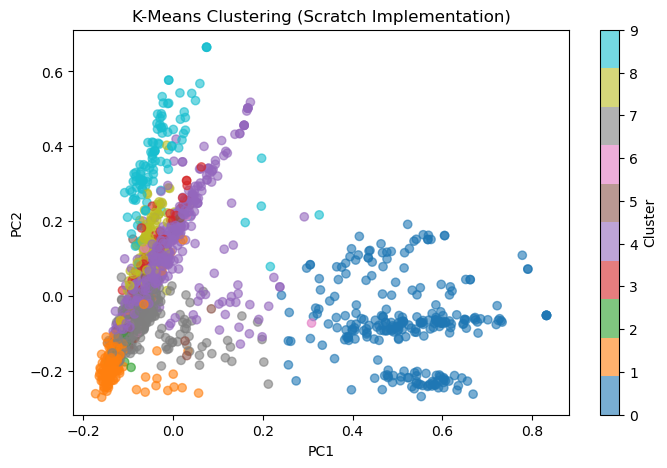

In [55]:
X_pca = PCA(n_components=2).fit_transform(X)
plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='tab10', alpha=0.6)
plt.title('K-Means Clustering (Scratch Implementation)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster')
plt.show()


## 7. Show Sample Emails per Cluster


In [58]:
for i in range(k):
    print(f"\n--- Cluster {i} sample emails ---")
    print(filtered_df[filtered_df['cluster_scratch'] == i]['cleaned_body'].iloc[:2].values)



--- Cluster 0 sample emails ---
["Shirley,\n\nIt's OK. \n\nVince\n\n\n\n\nShirley Crenshaw\n01/09/2001 03:36 PM"
 'Shirley,\n\nFYI\n\nVince']

--- Cluster 1 sample emails ---
['Hello Shmuel,\n\nThanks for your message. The end of 2000 and the beginning of 2001 were \nextremely busy \nand I could not focus on PSERC issues. I shall consult a few people in Enron \non this subject and get in\ntouch with you. Our concern right now is that the results of research are \nwidely shared with\nour competition.\n\nI am out on the 19th, but the 20th would work for me. I would be glad to \ncover the cost of your Austin\nto Houston trip.\n\nRegarding your son. The Analyst / Associate program will interview again on \nthe campus\nin the spring and they will be more than happy to interview him.\n\n\n\n\n\n"Shmuel Oren" <oren@ieor.berkeley.edu> on 12/19/2000 01:40:02 PM'
 "Nick,\n\nThanks for your message. My family is in Houston for the Christmas holidays\nand  this means I am not coming any time soon